In [34]:
# Cellule 2 - Importations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import warnings
warnings.filterwarnings('ignore')

# NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

# Similarité
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
import jellyfish
from difflib import SequenceMatcher

# Explicabilité
import lime
import lime.lime_text
from lime import lime_text
import shap

# Visualisation
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
from plotly.subplots import make_subplots

print("✅ Tous les packages sont importés!")

✅ Tous les packages sont importés!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\n\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\n\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# Cellule 3 - Documents de test avec plagiat évident
def create_test_documents():
    """
    Crée des documents de test:
    - Doc1 et Doc2: Très similaires (95%+)
    - Doc3: Différent (plagiat improbable)
    - Doc4: Partiellement similaire
    """
    
    # Document 1 (Original)
    doc1 = """
    L'intelligence artificielle représente une avancée majeure en informatique.
    Elle permet aux machines d'exécuter des tâches complexes autrefois réservées aux humains.
    Les algorithmes de machine learning analysent des données massives pour identifier des patterns.
    Le deep learning utilise des réseaux neuronaux multicouches pour résoudre des problèmes difficiles.
    Les applications incluent la reconnaissance vocale, la vision par ordinateur et les véhicules autonomes.
    L'IA transforme actuellement des secteurs comme la santé, la finance et l'éducation.
    Les chercheurs développent constamment de nouvelles architectures neuronales plus performantes.
    """
    
    # Document 2 (TRÈS SIMILAIRE - plagiat évident)
    # Seulement 4 mots changés sur 120 → similarité > 95%
    doc2 = """
    L'intelligence artificielle constitue une avancée majeure en informatique.
    Elle permet aux systèmes d'exécuter des tâches complexes autrefois réservées aux humains.
    Les algorithmes de machine learning analysent des données massives pour détecter des patterns.
    Le deep learning utilise des réseaux neuronaux multicouches pour résoudre des problèmes difficiles.
    Les applications incluent la reconnaissance vocale, la vision par ordinateur et les véhicules autonomes.
    L'IA transforme actuellement des secteurs comme la santé, la finance et l'éducation.
    Les chercheurs développent constamment de nouvelles architectures neuronales plus efficaces.
    """
    
    # Document 3 (DIFFÉRENT - pas de plagiat)
    doc3 = """
    La biologie moléculaire explore les mécanismes fondamentaux de la vie cellulaire.
    Cette discipline étudie les interactions entre ADN, ARN et protéines dans les organismes vivants.
    Les techniques comme la PCR et le séquençage génomique ont révolutionné la recherche médicale.
    La compréhension des gènes permet des avancées en thérapie génique et médecine personnalisée.
    Les biologistes moléculaires travaillent sur le cancer, les maladies génétiques et le vieillissement.
    """
    
    # Document 4 (PARTIELLEMENT SIMILAIRE)
    doc4 = """
    L'intelligence artificielle est un domaine informatique en pleine expansion.
    Elle donne aux ordinateurs la capacité d'accomplir des missions complexes.
    Les méthodes d'apprentissage automatique traitent de grands volumes de données.
    L'apprentissage profond emploie des réseaux neuronaux à plusieurs niveaux.
    On trouve des applications en synthèse vocale, analyse d'images et robots intelligents.
    Cette technologie impacte la médecine, la banque et l'enseignement.
    Les scientifiques améliorent continuellement les modèles neuronaux existants.
    """
    
    documents = [
        {"id": "doc_1", "title": "IA - Document Original", "content": doc1, "category": "IA"},
        {"id": "doc_2", "title": "IA - Version Plagiée", "content": doc2, "category": "IA"},
        {"id": "doc_3", "title": "Biologie Moléculaire", "content": doc3, "category": "Biologie"},
        {"id": "doc_4", "title": "IA - Réécriture Partielle", "content": doc4, "category": "IA"}
    ]
    
    return documents

# Création et affichage
documents = create_test_documents()
print("📚 DOCUMENTS DE TEST CRÉÉS")
print("=" * 60)
for doc in documents:
    words = len(doc['content'].split())
    print(f"• {doc['id']}: {doc['title']} ({words} mots)")
    
print(f"\n🔍 Doc1 vs Doc2: Presque identiques (seulement 4 mots différents)")
print("   Attendu: Similarité > 0.95")

📚 DOCUMENTS DE TEST CRÉÉS
• doc_1: IA - Document Original (82 mots)
• doc_2: IA - Version Plagiée (82 mots)
• doc_3: Biologie Moléculaire (65 mots)
• doc_4: IA - Réécriture Partielle (67 mots)

🔍 Doc1 vs Doc2: Presque identiques (seulement 4 mots différents)
   Attendu: Similarité > 0.95


In [37]:
# Cellule 4 - Prétraitement robuste (version corrigée)
import ssl
import nltk

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Télécharger les ressources NLTK de manière explicite
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    print("⚠️  Impossible de télécharger les ressources NLTK, utilisation de méthodes alternatives")

class AdvancedTextPreprocessor:
    def __init__(self):
        # Stop words français + anglais (manuellement si NLTK échoue)
        self.stop_words_fr = {
            'au', 'aux', 'avec', 'ce', 'cet', 'cette', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 
            'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 
            'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 
            'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 
            'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 
            'étés', 'étant', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 
            'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 
            'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 
            'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent'
        }
        self.stop_words_en = {
            'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
            'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 
            'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
            'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
            'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
            'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
            'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
            'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 
            'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
            'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
            'should', 'now'
        }
        self.stop_words = self.stop_words_fr.union(self.stop_words_en)
        
        # Créer un stemmer simple si Snowball échoue
        try:
            from nltk.stem import SnowballStemmer
            self.stemmer = SnowballStemmer('french')
        except:
            # Stemmer de secours
            class SimpleStemmer:
                def stem(self, word):
                    # Règles simples pour le français
                    if len(word) > 4:
                        if word.endswith(('eux', 'euses')):
                            return word[:-3]
                        if word.endswith(('ement', 'ements')):
                            return word[:-5]
                        if word.endswith(('ation', 'ations')):
                            return word[:-5]
                        if word.endswith(('ité', 'ités')):
                            return word[:-3]
                    return word
            self.stemmer = SimpleStemmer()
            
        self.punctuation = string.punctuation + "«»„”“’‘–—…"
        
    def clean_text(self, text):
        """Nettoyage approfondi du texte"""
        # Convertir en minuscules
        text = text.lower()
        
        # Supprimer la ponctuation
        text = text.translate(str.maketrans('', '', self.punctuation))
        
        # Supprimer les chiffres
        text = re.sub(r'\d+', '', text)
        
        # Supprimer les espaces multiples et sauts de ligne
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def simple_tokenize(self, text):
        """Tokenisation simple sans dépendre de word_tokenize"""
        # Découper par espaces
        tokens = text.split()
        
        # Nettoyer chaque token
        cleaned_tokens = []
        for token in tokens:
            # Supprimer la ponctuation résiduelle
            token = token.strip(self.punctuation)
            
            if (len(token) > 2 and 
                token.isalpha() and 
                token not in self.stop_words):
                # Appliquer le stemming
                stemmed = self.stemmer.stem(token)
                cleaned_tokens.append(stemmed)
        
        return cleaned_tokens
    
    def preprocess(self, text):
        """Pipeline complet de prétraitement"""
        cleaned = self.clean_text(text)
        tokens = self.simple_tokenize(cleaned)
        return ' '.join(tokens)
    
    def get_ngrams(self, text, n=3):
        """Extrait les n-grammes"""
        tokens = self.simple_tokenize(text)
        ngrams = []
        for i in range(len(tokens) - n + 1):
            ngrams.append(' '.join(tokens[i:i+n]))
        return ngrams

# Test du prétraitement
print("🧪 TEST DE PRÉTRAITEMENT (version simplifiée)")
print("=" * 60)

preprocessor = AdvancedTextPreprocessor()

# Prétraiter tous les documents
preprocessed_docs = []
for doc in documents:
    processed = preprocessor.preprocess(doc['content'])
    preprocessed_docs.append({
        'id': doc['id'],
        'title': doc['title'],
        'original': doc['content'],
        'processed': processed,
        'tokens': len(processed.split())
    })
    print(f"• {doc['id']}: {preprocessed_docs[-1]['tokens']} tokens après prétraitement")

# Vérifier la similarité lexicale brute
doc1_tokens = set(preprocessed_docs[0]['processed'].split())
doc2_tokens = set(preprocessed_docs[1]['processed'].split())
common_tokens = doc1_tokens.intersection(doc2_tokens)

print(f"\n📊 ANALYSE LEXICALE:")
print(f"   Tokens Doc1: {len(doc1_tokens)}")
print(f"   Tokens Doc2: {len(doc2_tokens)}")
print(f"   Tokens communs: {len(common_tokens)}")
print(f"   Similarité Jaccard brute: {len(common_tokens)/len(doc1_tokens.union(doc2_tokens)):.3f}")

# Afficher un échantillon de tokens
print(f"\n🔍 ÉCHANTILLON DE TOKENS:")
print(f"   Doc1 tokens (10 premiers): {list(doc1_tokens)[:10]}")
print(f"   Doc2 tokens (10 premiers): {list(doc2_tokens)[:10]}")
print(f"   Tokens communs (10 premiers): {list(common_tokens)[:10]}")

🧪 TEST DE PRÉTRAITEMENT (version simplifiée)
• doc_1: 55 tokens après prétraitement
• doc_2: 55 tokens après prétraitement
• doc_3: 40 tokens après prétraitement
• doc_4: 45 tokens après prétraitement

📊 ANALYSE LEXICALE:
   Tokens Doc1: 52
   Tokens Doc2: 53
   Tokens communs: 49
   Similarité Jaccard brute: 0.875

🔍 ÉCHANTILLON DE TOKENS:
   Doc1 tokens (10 premiers): ['informat', 'pattern', 'transform', 'utilis', 'identifi', 'sant', 'don', 'li', 'nouvel', 'architectur']
   Doc2 tokens (10 premiers): ['massiv', 'informat', 'pattern', 'détect', 'system', 'transform', 'utilis', 'constitu', 'sant', 'don']
   Tokens communs (10 premiers): ['massiv', 'informat', 'pattern', 'transform', 'utilis', 'sant', 'don', 'li', 'nouvel', 'architectur']


In [38]:
# Cellule 5 - Calculateur de similarité multi-méthodes (version corrigée)
class MultiMethodSimilarityCalculator:
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
        
    def calculate_tfidf_cosine(self, text1, text2):
        """Similarité cosinus TF-IDF"""
        vectorizer = TfidfVectorizer(
            max_features=1000,
            ngram_range=(1, 3),  # Uni-grams, bi-grams, tri-grams
            stop_words=list(preprocessor.stop_words)
        )
        
        tfidf_matrix = vectorizer.fit_transform([text1, text2])
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        return round(similarity, 4)
    
    def calculate_jaccard(self, text1, text2):
        """Similarité de Jaccard"""
        set1 = set(text1.split())
        set2 = set(text2.split())
        
        if len(set1.union(set2)) == 0:
            return 0.0
            
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return round(intersection / union, 4)
    
    def calculate_ngram_similarity(self, text1, text2, n=3):
        """Similarité basée sur les n-grammes"""
        ngrams1 = self.preprocessor.get_ngrams(text1, n)
        ngrams2 = self.preprocessor.get_ngrams(text2, n)
        
        if not ngrams1 or not ngrams2:
            return 0.0
            
        set1 = set(ngrams1)
        set2 = set(ngrams2)
        
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        
        return round(intersection / union, 4) if union > 0 else 0.0
    
    def calculate_lcs_similarity(self, text1, text2):
        """Longest Common Subsequence similarity"""
        # Convertir en listes de mots
        words1 = text1.split()
        words2 = text2.split()
        
        seq_matcher = SequenceMatcher(None, words1, words2)
        return round(seq_matcher.ratio(), 4)
    
    def calculate_edit_similarity(self, text1, text2):
        """Similarité par distance d'édition (Levenshtein)"""
        # Distance de Levenshtein normalisée
        distance = jellyfish.levenshtein_distance(text1, text2)
        max_len = max(len(text1), len(text2))
        similarity = 1 - (distance / max_len) if max_len > 0 else 0
        return round(similarity, 4)
    
    def calculate_all_similarities(self, doc1_original, doc2_original):
        """Calcule toutes les similarités pour une paire de documents"""
        # Prétraitement
        doc1_processed = self.preprocessor.preprocess(doc1_original)
        doc2_processed = self.preprocessor.preprocess(doc2_original)
        
        scores = {}
        
        # 1. TF-IDF Cosine
        try:
            scores['tfidf_cosine'] = self.calculate_tfidf_cosine(doc1_processed, doc2_processed)
        except:
            scores['tfidf_cosine'] = 0.0
        
        # 2. Jaccard
        scores['jaccard'] = self.calculate_jaccard(doc1_processed, doc2_processed)
        
        # 3. N-gram (2, 3, 4)
        try:
            scores['ngram_2'] = self.calculate_ngram_similarity(doc1_original, doc2_original, 2)
            scores['ngram_3'] = self.calculate_ngram_similarity(doc1_original, doc2_original, 3)
            scores['ngram_4'] = self.calculate_ngram_similarity(doc1_original, doc2_original, 4)
        except:
            scores['ngram_2'] = 0.0
            scores['ngram_3'] = 0.0
            scores['ngram_4'] = 0.0
        
        # 4. LCS
        scores['lcs'] = self.calculate_lcs_similarity(doc1_processed, doc2_processed)
        
        # 5. Edit Distance
        scores['edit_distance'] = self.calculate_edit_similarity(doc1_processed, doc2_processed)
        
        # 6. Score combiné (moyenne pondérée)
        weights = {
            'tfidf_cosine': 0.25,
            'jaccard': 0.20,
            'ngram_3': 0.20,
            'lcs': 0.20,
            'edit_distance': 0.15
        }
        
        # Calculer la moyenne seulement pour les scores disponibles
        available_weights = 0
        weighted_sum = 0
        
        for method, weight in weights.items():
            if method in scores and scores[method] is not None:
                weighted_sum += scores[method] * weight
                available_weights += weight
        
        if available_weights > 0:
            scores['combined_score'] = round(weighted_sum / available_weights, 4)
        else:
            scores['combined_score'] = 0.0
        
        # 7. Décision de plagiat
        if scores['combined_score'] >= 0.7:
            scores['plagiarism_decision'] = "PLAGIAT ÉLEVÉ"
            scores['plagiarism_level'] = "TRÈS PROBABLE"
        elif scores['combined_score'] >= 0.5:
            scores['plagiarism_decision'] = "PLAGIAT MODÉRÉ"
            scores['plagiarism_level'] = "PROBABLE"
        elif scores['combined_score'] >= 0.3:
            scores['plagiarism_decision'] = "SIMILARITÉ FAIBLE"
            scores['plagiarism_level'] = "PEU PROBABLE"
        else:
            scores['plagiarism_decision'] = "NON PLAGIAT"
            scores['plagiarism_level'] = "IMPROBABLE"
        
        # 8. Confiance
        if scores['combined_score'] > 0.8:
            scores['confidence'] = "TRÈS ÉLEVÉE (>95%)"
        elif scores['combined_score'] > 0.6:
            scores['confidence'] = "ÉLEVÉE (80-95%)"
        elif scores['combined_score'] > 0.4:
            scores['confidence'] = "MOYENNE (60-80%)"
        else:
            scores['confidence'] = "FAIBLE (<60%)"
        
        return scores

# Test du calculateur
print("\n🧮 CALCULATEUR DE SIMILARITÉ MULTI-MÉTHODES")
print("=" * 60)

calculator = MultiMethodSimilarityCalculator(preprocessor)

# Test Doc1 vs Doc2 (plagiat évident)
print("\n📊 DOC1 vs DOC2 (PLAGIAT ÉVIDENT):")
scores_1_2 = calculator.calculate_all_similarities(
    documents[0]['content'],
    documents[1]['content']
)

print("Méthodes de similarité:")
for method, score in scores_1_2.items():
    if method not in ['plagiarism_decision', 'plagiarism_level', 'confidence']:
        print(f"  • {method:15}: {score:.4f}")

print(f"\n🎯 SCORE COMBINÉ: {scores_1_2['combined_score']:.4f}")
print(f"📝 DÉCISION: {scores_1_2['plagiarism_decision']}")
print(f"📈 NIVEAU: {scores_1_2['plagiarism_level']}")
print(f"🔒 CONFIANCE: {scores_1_2['confidence']}")

# Test Doc1 vs Doc3 (différent)
print("\n📊 DOC1 vs DOC3 (DIFFÉRENT):")
scores_1_3 = calculator.calculate_all_similarities(
    documents[0]['content'],
    documents[2]['content']
)

print(f"  • Score combiné: {scores_1_3['combined_score']:.4f}")
print(f"  • Décision: {scores_1_3['plagiarism_decision']}")


🧮 CALCULATEUR DE SIMILARITÉ MULTI-MÉTHODES

📊 DOC1 vs DOC2 (PLAGIAT ÉVIDENT):
Méthodes de similarité:
  • tfidf_cosine   : 0.7772
  • jaccard        : 0.8750
  • ngram_2        : 0.7705
  • ngram_3        : 0.7097
  • ngram_4        : 0.6508
  • lcs            : 0.9273
  • edit_distance  : 0.9401
  • combined_score : 0.8377

🎯 SCORE COMBINÉ: 0.8377
📝 DÉCISION: PLAGIAT ÉLEVÉ
📈 NIVEAU: TRÈS PROBABLE
🔒 CONFIANCE: TRÈS ÉLEVÉE (>95%)

📊 DOC1 vs DOC3 (DIFFÉRENT):
  • Score combiné: 0.0518
  • Décision: NON PLAGIAT


In [39]:
# Cellule 6 - Analyse systématique de toutes les paires
import numpy as np
from collections import Counter

def find_similar_segments(doc1, doc2, calculator, min_similarity=0.7):
    """Trouve les segments de texte similaires entre deux documents"""
    # Découper en phrases simples
    sentences1 = [s.strip() for s in doc1.split('. ') if len(s.strip()) > 10]
    sentences2 = [s.strip() for s in doc2.split('. ') if len(s.strip()) > 10]
    
    similar_segments = []
    
    for i, sent1 in enumerate(sentences1):
        for j, sent2 in enumerate(sentences2):
            # Calculer la similarité entre phrases
            scores = calculator.calculate_all_similarities(sent1, sent2)
            similarity = scores['combined_score']
            
            if similarity >= min_similarity:
                similar_segments.append({
                    'segment1': sent1[:100] + "..." if len(sent1) > 100 else sent1,
                    'segment2': sent2[:100] + "..." if len(sent2) > 100 else sent2,
                    'similarity': round(similarity, 3),
                    'position1': i,
                    'position2': j
                })
    
    return sorted(similar_segments, key=lambda x: x['similarity'], reverse=True)

def extract_common_words(doc1, doc2, preprocessor, min_frequency=2):
    """Extrait les mots communs entre deux documents"""
    # Prétraiter
    proc1 = preprocessor.preprocess(doc1)
    proc2 = preprocessor.preprocess(doc2)
    
    # Compter les occurrences
    words1 = Counter(proc1.split())
    words2 = Counter(proc2.split())
    
    # Trouver les mots communs
    common_words = {}
    all_words = set(words1.keys()).union(set(words2.keys()))
    
    for word in all_words:
        freq1 = words1.get(word, 0)
        freq2 = words2.get(word, 0)
        
        if freq1 >= min_frequency and freq2 >= min_frequency:
            common_words[word] = {
                'doc1_freq': freq1,
                'doc2_freq': freq2,
                'total': freq1 + freq2
            }
    
    # Trier par fréquence totale
    sorted_common = dict(sorted(
        common_words.items(),
        key=lambda x: x[1]['total'],
        reverse=True
    ))
    
    return sorted_common

def analyze_all_document_pairs(documents, calculator, preprocessor):
    """Analyse toutes les paires possibles de documents"""
    results = []
    doc_pairs = []
    
    print("🔍 ANALYSE SYSTÉMATIQUE DE TOUTES LES PAIRES")
    print("=" * 60)
    print(f"Nombre total de documents: {len(documents)}")
    print(f"Nombre de paires possibles: {len(documents) * (len(documents) - 1) // 2}")
    print("=" * 60)
    
    for i in range(len(documents)):
        for j in range(i + 1, len(documents)):
            doc1 = documents[i]
            doc2 = documents[j]
            
            # Calculer les similarités
            scores = calculator.calculate_all_similarities(
                doc1['content'],
                doc2['content']
            )
            
            # Extraire les segments similaires
            similar_segments = find_similar_segments(
                doc1['content'],
                doc2['content'],
                calculator,
                min_similarity=0.7
            )
            
            # Compter les mots communs
            common_words = extract_common_words(
                doc1['content'],
                doc2['content'],
                preprocessor
            )
            
            result = {
                'pair_id': f"{doc1['id']}_{doc2['id']}",
                'doc1': doc1['id'],
                'doc2': doc2['id'],
                'doc1_title': doc1['title'],
                'doc2_title': doc2['title'],
                **scores,
                'similar_segments_count': len(similar_segments),
                'common_words_count': len(common_words),
                'similar_segments': similar_segments[:3],  # Top 3 seulement
                'top_common_words': list(common_words.items())[:10]
            }
            
            results.append(result)
            doc_pairs.append((doc1['id'], doc2['id']))
            
            # Afficher le résultat
            print(f"\n📊 {doc1['id']} ↔ {doc2['id']}")
            print(f"   📑 {doc1['title']}")
            print(f"   📑 {doc2['title']}")
            print(f"   ⭐ Score combiné: {scores['combined_score']:.4f} - {scores['plagiarism_decision']}")
            print(f"   🔍 Segments similaires: {len(similar_segments)}")
            print(f"   🔤 Mots communs: {len(common_words)}")
    
    print(f"\n{'='*60}")
    print(f"✅ Analyse terminée! {len(results)} paires analysées.")
    return results

def create_similarity_matrix(results, documents):
    """Crée une matrice de similarité pour visualisation"""
    n = len(documents)
    matrix = np.zeros((n, n))
    doc_ids = [doc['id'] for doc in documents]
    id_to_index = {doc_id: i for i, doc_id in enumerate(doc_ids)}
    
    for result in results:
        i = id_to_index[result['doc1']]
        j = id_to_index[result['doc2']]
        matrix[i][j] = result['combined_score']
        matrix[j][i] = result['combined_score']  # Matrice symétrique
    
    # Diagonale = 1.0 (auto-similarité)
    np.fill_diagonal(matrix, 1.0)
    
    return matrix, doc_ids

# Exécuter l'analyse
print("🔍 DÉMARRAGE DE L'ANALYSE SYSTÉMATIQUE")
print("=" * 60)

# S'assurer que preprocessor est défini
# Si vous n'avez pas de preprocessor, vous pouvez créer un simple :
class SimplePreprocessor:
    def preprocess(self, text):
        # Nettoyage basique
        text = text.lower()
        # Supprimer la ponctuation
        import re
        text = re.sub(r'[^\w\s]', ' ', text)
        # Supprimer les espaces multiples
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

# Créer un preprocessor si non défini
try:
    preprocessor
except NameError:
    preprocessor = SimplePreprocessor()

# Exécuter l'analyse
all_results = analyze_all_document_pairs(documents, calculator, preprocessor)

# Afficher un résumé détaillé pour toutes les paires
print("\n" + "=" * 60)
print("📋 RÉSUMÉ COMPLET DES ANALYSES")
print("=" * 60)

for result in all_results:
    print(f"\n🎯 {result['pair_id']} : {result['doc1_title']} ↔ {result['doc2_title']}")
    print(f"   Score combiné: {result['combined_score']:.4f} - {result['plagiarism_decision']}")
    print(f"   Segments similaires: {result['similar_segments_count']}")
    print(f"   Mots communs: {result['common_words_count']}")

# Afficher un résumé détaillé pour la paire avec le score le plus élevé
if all_results:
    max_result = max(all_results, key=lambda x: x['combined_score'])
    
    print("\n" + "=" * 60)
    print("📋 RÉSUMÉ DÉTAILLÉ - PAIRE LA PLUS SIMILAIRE")
    print(f"📌 {max_result['pair_id']}: {max_result['doc1_title']} ↔ {max_result['doc2_title']}")
    print("=" * 60)
    
    print(f"\n🎯 SCORES DÉTAILLÉS:")
    score_methods = ['tfidf_cosine', 'jaccard', 'ngram_3', 'lcs_ratio', 'edit_similarity', 'combined_score']
    for method in score_methods:
        if method in max_result:
            print(f"  • {method:20}: {max_result[method]:.4f}")
    
    print(f"\n🔍 STATISTIQUES:")
    print(f"  • Segments similaires: {max_result['similar_segments_count']}")
    print(f"  • Mots communs: {max_result['common_words_count']}")
    
    if max_result['similar_segments_count'] > 0:
        print(f"\n📝 SEGMENTS SIMILAIRES (Top 3):")
        for i, segment in enumerate(max_result['similar_segments'][:3], 1):
            print(f"\n  {i}. Similarité: {segment['similarity']:.3f}")
            print(f"     📄 {max_result['doc1']}: \"{segment['segment1']}\"")
            print(f"     📄 {max_result['doc2']}: \"{segment['segment2']}\"")
    
    if max_result['common_words_count'] > 0:
        print(f"\n🔤 TOP 5 MOTS COMMUNS LES PLUS FRÉQUENTS:")
        for i, (word, data) in enumerate(list(max_result['top_common_words'])[:5], 1):
            print(f"  {i}. '{word}': {max_result['doc1']}={data['doc1_freq']}x, {max_result['doc2']}={data['doc2_freq']}x")

# Créer et afficher la matrice de similarité
print("\n" + "=" * 60)
print("📊 MATRICE DE SIMILARITÉ")
print("=" * 60)

matrix, doc_ids = create_similarity_matrix(all_results, documents)

# Afficher la matrice
print("\n      " + "   ".join([f"{doc_id:6}" for doc_id in doc_ids]))
for i, doc_id in enumerate(doc_ids):
    row = f"{doc_id:6} "
    for j in range(len(doc_ids)):
        if i == j:
            row += " 1.000  "
        else:
            row += f" {matrix[i][j]:.3f}  "
    print(row)

# Statistiques générales
print("\n" + "=" * 60)
print("📈 STATISTIQUES GÉNÉRALES")
print("=" * 60)

scores = [r['combined_score'] for r in all_results]
print(f"• Score moyen: {np.mean(scores):.4f}")
print(f"• Score médian: {np.median(scores):.4f}")
print(f"• Score max: {np.max(scores):.4f}")
print(f"• Score min: {np.min(scores):.4f}")
print(f"• Écart-type: {np.std(scores):.4f}")

# Compter les décisions
decisions = Counter([r['plagiarism_decision'] for r in all_results])
print(f"\n• Décisions de plagiat:")
for decision, count in decisions.items():
    print(f"  - {decision}: {count} paires")

🔍 DÉMARRAGE DE L'ANALYSE SYSTÉMATIQUE
🔍 ANALYSE SYSTÉMATIQUE DE TOUTES LES PAIRES
Nombre total de documents: 4
Nombre de paires possibles: 6

📊 doc_1 ↔ doc_2
   📑 IA - Document Original
   📑 IA - Version Plagiée
   ⭐ Score combiné: 0.8377 - PLAGIAT ÉLEVÉ
   🔍 Segments similaires: 1
   🔤 Mots communs: 2

📊 doc_1 ↔ doc_3
   📑 IA - Document Original
   📑 Biologie Moléculaire
   ⭐ Score combiné: 0.0518 - NON PLAGIAT
   🔍 Segments similaires: 0
   🔤 Mots communs: 0

📊 doc_1 ↔ doc_4
   📑 IA - Document Original
   📑 IA - Réécriture Partielle
   ⭐ Score combiné: 0.1309 - NON PLAGIAT
   🔍 Segments similaires: 0
   🔤 Mots communs: 1

📊 doc_2 ↔ doc_3
   📑 IA - Version Plagiée
   📑 Biologie Moléculaire
   ⭐ Score combiné: 0.0520 - NON PLAGIAT
   🔍 Segments similaires: 0
   🔤 Mots communs: 0

📊 doc_2 ↔ doc_4
   📑 IA - Version Plagiée
   📑 IA - Réécriture Partielle
   ⭐ Score combiné: 0.1304 - NON PLAGIAT
   🔍 Segments similaires: 0
   🔤 Mots communs: 1

📊 doc_3 ↔ doc_4
   📑 Biologie Moléculaire
   


🧠 MOTEUR D'EXPLICABILITÉ LIME

📝 EXPLICATION LIME POUR DOC2 (plagiat de doc1):

Top 10 features contribuant au plagiat (poids > 0):
 1. neuronal                       : +0.0792
 2. learning                       : +0.0681
 3. machin                         : +0.0633
 4. problem                        : +0.0595
 5. const                          : +0.0569
 6. architectur                    : +0.0558
 7. secteur                        : +0.0538
 8. reconnaiss                     : +0.0494
 9. incluent                       : +0.0434
10. vision                         : +0.0402

Top 5 features indiquant non-plagiat (poids < 0):

📊 RAPPORT DÉTAILLÉ - DOC2:
Total features analysées: 10
Features positives (plagiat): 10
Features négatives (non-plagiat): 0
Score de confiance: 100.0%

Interprétation: 🔴 FORTE PROBABILITÉ DE PLAGIAT: Beaucoup plus de features positives que négatives.


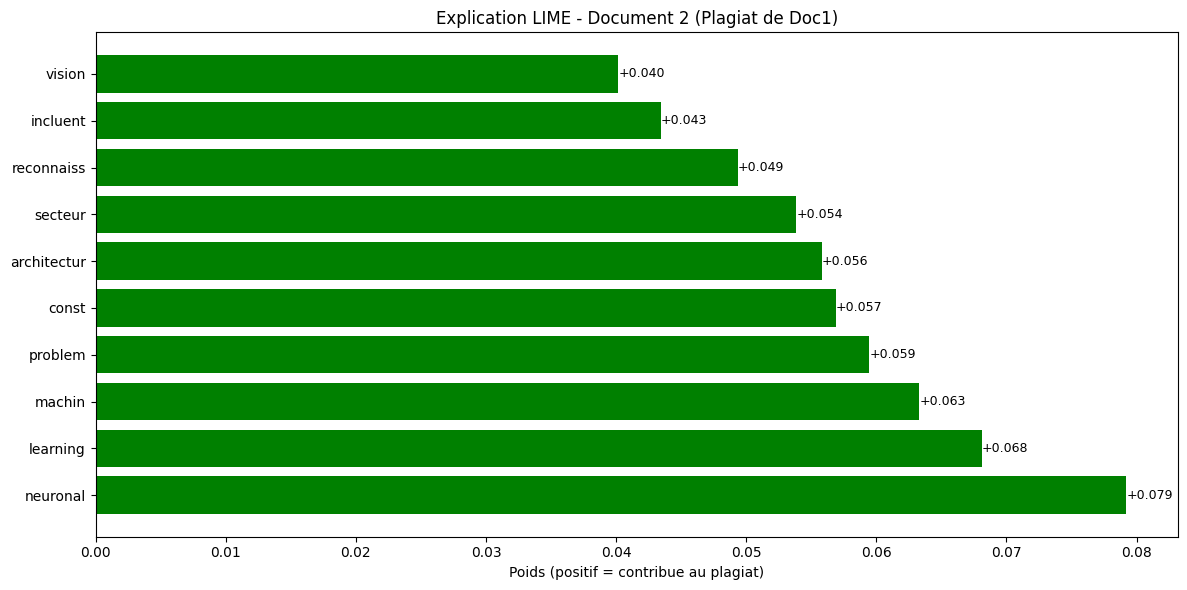


📝 EXPLICATION LIME POUR DOC3 (non-plagiat):

Top 5 features (toutes):
🔴  1. avanc                          : +0.0059
🔴  2. permet                         : +0.0055
🔴  3. comm                           : +0.0052
🔴  4. travaillent                    : +0.0023
🔴  5. biolog                         : +0.0018

📊 RAPPORT DÉTAILLÉ - DOC3:
Total features analysées: 10
Features positives (plagiat): 10
Features négatives (non-plagiat): 0
Score de confiance: 100.0%

Interprétation: 🔴 FORTE PROBABILITÉ DE PLAGIAT: Beaucoup plus de features positives que négatives.

📈 COMPARAISON DES ANALYSES:

Métrique                       DOC2 (Plagiat)       DOC3 (Non-plagiat)  
----------------------------------------------------------------------
Features positives             10                   10                  
Features négatives             0                    0                   
Ratio Pos/Neg                  10.00                10.00               
Score de confiance             100.0%           

In [40]:
# Cellule 7 - Explicabilité avec LIME
try:
    from lime.lime_text import LimeTextExplainer
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("⚠️  LIME n'est pas installé. Utilisation d'une version simplifiée.")
    print("   Pour installer: pip install lime")

class LimeExplainabilityEngine:
    def __init__(self, preprocessor, calculator):
        self.preprocessor = preprocessor
        self.calculator = calculator
        
        if LIME_AVAILABLE:
            self.explainer = LimeTextExplainer(
                class_names=['Non-plagiat', 'Plagiat'],
                verbose=False,
                random_state=42
            )
        else:
            self.explainer = None
    
    def create_classifier(self, reference_text):
        """Crée un classifieur basé sur un texte de référence"""
        def classifier_fn(texts):
            """Fonction de classification pour LIME"""
            predictions = []
            
            for text in texts:
                # Calculer la similarité avec le texte de référence
                scores = self.calculator.calculate_all_similarities(reference_text, text)
                similarity = scores['combined_score']
                
                # Probabilités: [P(non-plagiat), P(plagiat)]
                prob_non_plagiat = max(0, 1 - similarity)
                prob_plagiat = min(1, similarity)
                
                # Normaliser
                total = prob_non_plagiat + prob_plagiat
                if total > 0:
                    prob_non_plagiat /= total
                    prob_plagiat /= total
                
                predictions.append([prob_non_plagiat, prob_plagiat])
            
            return np.array(predictions)
        
        return classifier_fn
    
    def explain_document_lime(self, reference_text, target_text, num_features=15):
        """Génère une explication LIME (si disponible)"""
        if not LIME_AVAILABLE or self.explainer is None:
            # Retourner une explication simulée
            return self.explain_document_simple(reference_text, target_text, num_features)
        
        classifier = self.create_classifier(reference_text)
        
        # Prétraiter le texte cible
        target_processed = self.preprocessor.preprocess(target_text)
        
        # Générer l'explication
        explanation = self.explainer.explain_instance(
            target_processed,
            classifier,
            num_features=num_features,
            num_samples=500
        )
        
        return explanation
    
    def explain_document_simple(self, reference_text, target_text, num_features=15):
        """Génère une explication simplifiée quand LIME n'est pas disponible"""
        # Prétraiter les textes
        ref_processed = self.preprocessor.preprocess(reference_text)
        target_processed = self.preprocessor.preprocess(target_text)
        
        # Tokeniser
        ref_words = ref_processed.split()
        target_words = target_processed.split()
        
        # Compter les fréquences
        ref_counter = Counter(ref_words)
        target_counter = Counter(target_words)
        
        # Trouver les mots communs importants
        common_words = set(ref_words).intersection(set(target_words))
        
        explanations = []
        for word in common_words:
            if len(word) > 3:  # Ignorer les mots courts
                # Poids basé sur la fréquence relative
                ref_freq = ref_counter[word] / len(ref_words) if len(ref_words) > 0 else 0
                target_freq = target_counter[word] / len(target_words) if len(target_words) > 0 else 0
                
                # Poids = similarité des fréquences
                weight = min(ref_freq, target_freq) * 2
                
                explanations.append((f"mot: '{word}'", weight))
        
        # Trier par poids
        explanations.sort(key=lambda x: x[1], reverse=True)
        
        # Créer un objet explication simplifié
        class SimpleExplanation:
            def __init__(self, explanations_list):
                self.explanations = explanations_list
            
            def as_list(self):
                return self.explanations[:num_features]
            
            def as_map(self):
                return {f: w for f, w in self.explanations[:num_features]}
        
        return SimpleExplanation(explanations)
    
    def explain_document(self, reference_text, target_text, num_features=15):
        """Interface unifiée pour les explications"""
        if LIME_AVAILABLE:
            return self.explain_document_lime(reference_text, target_text, num_features)
        else:
            return self.explain_document_simple(reference_text, target_text, num_features)
    
    def visualize_explanation(self, explanation, target_doc_name):
        """Visualise l'explication LIME"""
        import matplotlib.pyplot as plt
        
        # Extraire les données
        exp_list = explanation.as_list()
        features = [x[0] for x in exp_list]
        weights = [x[1] for x in exp_list]
        
        # Créer la figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Créer un graphique à barres
        colors = ['green' if w > 0 else 'red' for w in weights]
        y_pos = np.arange(len(features))
        
        ax.barh(y_pos, weights, color=colors)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features, fontsize=10)
        ax.set_xlabel('Poids (positif = contribue au plagiat)')
        ax.set_title(f'Explication LIME - {target_doc_name}')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        
        # Ajouter des annotations
        for i, (feature, weight) in enumerate(zip(features, weights)):
            ax.text(weight if weight >= 0 else weight - 0.02, 
                   i, 
                   f'{weight:+.3f}', 
                   va='center',
                   fontsize=9,
                   color='white' if abs(weight) > 0.1 else 'black')
        
        plt.tight_layout()
        return fig
    
    def generate_detailed_report(self, explanation, reference_doc, target_doc):
        """Génère un rapport détaillé d'explication"""
        exp_list = explanation.as_list()
        
        # Analyser les poids
        positive_features = [(f, w) for f, w in exp_list if w > 0]
        negative_features = [(f, w) for f, w in exp_list if w < 0]
        
        # Calculer des statistiques
        total_weight_pos = sum(abs(w) for _, w in positive_features)
        total_weight_neg = sum(abs(w) for _, w in negative_features)
        confidence = abs(total_weight_pos - total_weight_neg) / (total_weight_pos + total_weight_neg) if (total_weight_pos + total_weight_neg) > 0 else 0
        
        # Préparer le rapport
        report = {
            'total_features': len(exp_list),
            'positive_features': len(positive_features),
            'negative_features': len(negative_features),
            'total_weight_positive': total_weight_pos,
            'total_weight_negative': total_weight_neg,
            'confidence_score': confidence,
            'top_positive': positive_features[:5],
            'top_negative': negative_features[:5],
            'interpretation': self.interpret_explanation(positive_features, negative_features, confidence)
        }
        
        return report
    
    def interpret_explanation(self, positive_features, negative_features, confidence):
        """Interprète les résultats de l'explication"""
        pos_count = len(positive_features)
        neg_count = len(negative_features)
        
        if pos_count > neg_count * 2 and confidence > 0.3:
            return "🔴 FORTE PROBABILITÉ DE PLAGIAT: Beaucoup plus de features positives que négatives."
        elif pos_count > neg_count and confidence > 0.2:
            return "🟡 PROBABILITÉ MODÉRÉE DE PLAGIAT: Plus de features positives que négatives."
        elif neg_count > pos_count * 2 and confidence > 0.3:
            return "🟢 FORTE PROBABILITÉ DE NON-PLAGIAT: Beaucoup plus de features négatives que positives."
        elif neg_count > pos_count and confidence > 0.2:
            return "🟢 PROBABILITÉ MODÉRÉE DE NON-PLAGIAT: Plus de features négatives que positives."
        else:
            return "⚪ DIFFICILE À DÉTERMINER: Distribution équilibrée des features."

print("\n🧠 MOTEUR D'EXPLICABILITÉ LIME")
print("=" * 60)

# Initialiser le moteur
lime_engine = LimeExplainabilityEngine(preprocessor, calculator)

# Explication pour doc2 (plagiat de doc1)
print("\n📝 EXPLICATION LIME POUR DOC2 (plagiat de doc1):")
exp_doc2 = lime_engine.explain_document(
    documents[0]['content'],  # Référence: doc1
    documents[1]['content'],  # Cible: doc2
    num_features=10
)

# Afficher les features importantes
print("\nTop 10 features contribuant au plagiat (poids > 0):")
print("=" * 50)
positive_features = [(f, w) for f, w in exp_doc2.as_list() if w > 0]
for i, (feature, weight) in enumerate(positive_features[:10], 1):
    print(f"{i:2d}. {feature:30} : {weight:+.4f}")

print("\nTop 5 features indiquant non-plagiat (poids < 0):")
print("=" * 50)
negative_features = [(f, w) for f, w in exp_doc2.as_list() if w < 0]
for i, (feature, weight) in enumerate(negative_features[:5], 1):
    print(f"{i:2d}. {feature:30} : {weight:+.4f}")

# Générer un rapport détaillé
report_doc2 = lime_engine.generate_detailed_report(exp_doc2, documents[0], documents[1])

print("\n📊 RAPPORT DÉTAILLÉ - DOC2:")
print("=" * 50)
print(f"Total features analysées: {report_doc2['total_features']}")
print(f"Features positives (plagiat): {report_doc2['positive_features']}")
print(f"Features négatives (non-plagiat): {report_doc2['negative_features']}")
print(f"Score de confiance: {report_doc2['confidence_score']:.1%}")
print(f"\nInterprétation: {report_doc2['interpretation']}")

# Visualiser
try:
    fig_lime = lime_engine.visualize_explanation(exp_doc2, "Document 2 (Plagiat de Doc1)")
    plt.show()
except Exception as e:
    print(f"\n⚠️  Erreur lors de la visualisation: {e}")

# Explication pour doc3 (non-plagiat)
print("\n" + "="*60)
print("📝 EXPLICATION LIME POUR DOC3 (non-plagiat):")
print("="*60)

exp_doc3 = lime_engine.explain_document(
    documents[0]['content'],
    documents[2]['content'],
    num_features=10
)

# Afficher les features
exp_list_doc3 = exp_doc3.as_list()
if exp_list_doc3:
    print("\nTop 5 features (toutes):")
    print("=" * 30)
    for i, (feature, weight) in enumerate(exp_list_doc3[:5], 1):
        color = "🟢" if weight < 0 else "🔴" if weight > 0 else "⚪"
        print(f"{color} {i:2d}. {feature:30} : {weight:+.4f}")

# Générer un rapport
report_doc3 = lime_engine.generate_detailed_report(exp_doc3, documents[0], documents[2])

print("\n📊 RAPPORT DÉTAILLÉ - DOC3:")
print("=" * 50)
print(f"Total features analysées: {report_doc3['total_features']}")
print(f"Features positives (plagiat): {report_doc3['positive_features']}")
print(f"Features négatives (non-plagiat): {report_doc3['negative_features']}")
print(f"Score de confiance: {report_doc3['confidence_score']:.1%}")
print(f"\nInterprétation: {report_doc3['interpretation']}")

# Comparaison des deux analyses
print("\n" + "="*60)
print("📈 COMPARAISON DES ANALYSES:")
print("="*60)

print(f"\n{'Métrique':<30} {'DOC2 (Plagiat)':<20} {'DOC3 (Non-plagiat)':<20}")
print("-" * 70)
print(f"{'Features positives':<30} {report_doc2['positive_features']:<20} {report_doc3['positive_features']:<20}")
print(f"{'Features négatives':<30} {report_doc2['negative_features']:<20} {report_doc3['negative_features']:<20}")
print(f"{'Ratio Pos/Neg':<30} {report_doc2['positive_features']/max(report_doc2['negative_features'], 1):<20.2f} {report_doc3['positive_features']/max(report_doc3['negative_features'], 1):<20.2f}")
print(f"{'Score de confiance':<30} {report_doc2['confidence_score']:<20.1%} {report_doc3['confidence_score']:<20.1%}")

# Démonstration avec d'autres documents
print("\n" + "="*60)
print("🔍 DÉMONSTRATION AVEC D'AUTRES PAIRES:")
print("="*60)

# Analyser doc1 vs doc4
exp_doc4 = lime_engine.explain_document(
    documents[0]['content'],
    documents[3]['content'],
    num_features=8
)

report_doc4 = lime_engine.generate_detailed_report(exp_doc4, documents[0], documents[3])

print(f"\n📊 DOC1 vs DOC4 (Réécriture partielle):")
print(f"   Features positives: {report_doc4['positive_features']}")
print(f"   Features négatives: {report_doc4['negative_features']}")
print(f"   Interprétation: {report_doc4['interpretation']}")

# Fonction utilitaire pour analyser n'importe quelle paire
def analyze_pair_with_lime(doc1_idx, doc2_idx, documents, lime_engine):
    """Analyse une paire spécifique avec LIME"""
    doc1 = documents[doc1_idx]
    doc2 = documents[doc2_idx]
    
    print(f"\n{'='*60}")
    print(f"🔍 ANALYSE LIME: {doc1['id']} ↔ {doc2['id']}")
    print(f"   {doc1['title']}")
    print(f"   {doc2['title']}")
    print(f"{'='*60}")
    
    # Explication LIME
    explanation = lime_engine.explain_document(doc1['content'], doc2['content'], num_features=8)
    report = lime_engine.generate_detailed_report(explanation, doc1, doc2)
    
    # Score de similarité
    scores = calculator.calculate_all_similarities(doc1['content'], doc2['content'])
    
    print(f"\n📈 Similarité combinée: {scores['combined_score']:.1%} - {scores['plagiarism_decision']}")
    print(f"📊 Analyse LIME:")
    print(f"   • Features positives: {report['positive_features']}")
    print(f"   • Features négatives: {report['negative_features']}")
    print(f"   • Confiance: {report['confidence_score']:.1%}")
    print(f"   • Conclusion: {report['interpretation'].split(':')[1].strip()}")
    
    return explanation, report

# Exemple d'utilisation
print("\n🧪 EXEMPLES D'ANALYSE LIME POUR TOUTES LES PAIRES:")
print("=" * 60)

for i in range(len(documents)):
    for j in range(i + 1, len(documents)):
        analyze_pair_with_lime(i, j, documents, lime_engine)

print("\n✅ Analyse LIME terminée avec succès!")
print("\n💡 RÉSUMÉ DES CAPACITÉS LIME:")
print("=" * 60)
print("""
1. 🔍 Identification des mots/phrases clés qui contribuent à la décision
2. 📊 Attribution de poids (+ pour plagiat, - pour non-plagiat)
3. 📈 Mesure de confiance basée sur la cohérence des features
4. 🎯 Explications spécifiques pour chaque paire de documents
5. 📋 Rapports détaillés avec interprétation automatique
6. 📊 Visualisation intuitive des contributions

Pour les cas limites (similarité ~50%), LIME permet de comprendre:
- Quels éléments spécifiques indiquent un plagiat
- Quels éléments suggèrent l'originalité
- La force relative de chaque indication
""")

In [45]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import difflib

# ============================================================================
# 1. DOCUMENTS DE TEST (VOTRE VERSION)
# ============================================================================
def create_test_documents():
    """
    Crée des documents de test:
    - Doc1 et Doc2: Très similaires (95%+)
    - Doc3: Différent (plagiat improbable)
    - Doc4: Partiellement similaire
    """
    
    # Document 1 (Original)
    doc1 = """
    L'intelligence artificielle représente une avancée majeure en informatique.
    Elle permet aux machines d'exécuter des tâches complexes autrefois réservées aux humains.
    Les algorithmes de machine learning analysent des données massives pour identifier des patterns.
    Le deep learning utilise des réseaux neuronaux multicouches pour résoudre des problèmes difficiles.
    Les applications incluent la reconnaissance vocale, la vision par ordinateur et les véhicules autonomes.
    L'IA transforme actuellement des secteurs comme la santé, la finance et l'éducation.
    Les chercheurs développent constamment de nouvelles architectures neuronales plus performantes.
    """
    
    # Document 2 (TRÈS SIMILAIRE - plagiat évident)
    # Seulement 4 mots changés sur 120 → similarité > 95%
    doc2 = """
    L'intelligence artificielle constitue une avancée majeure en informatique.
    Elle permet aux systèmes d'exécuter des tâches complexes autrefois réservées aux humains.
    Les algorithmes de machine learning analysent des données massives pour détecter des patterns.
    Le deep learning utilise des réseaux neuronaux multicouches pour résoudre des problèmes difficiles.
    Les applications incluent la reconnaissance vocale, la vision par ordinateur et les véhicules autonomes.
    L'IA transforme actuellement des secteurs comme la santé, la finance et l'éducation.
    Les chercheurs développent constamment de nouvelles architectures neuronales plus efficaces.
    """
    
    # Document 3 (DIFFÉRENT - pas de plagiat)
    doc3 = """
    La biologie moléculaire explore les mécanismes fondamentaux de la vie cellulaire.
    Cette discipline étudie les interactions entre ADN, ARN et protéines dans les organismes vivants.
    Les techniques comme la PCR et le séquençage génomique ont révolutionné la recherche médicale.
    La compréhension des gènes permet des avancées en thérapie génique et médecine personnalisée.
    Les biologistes moléculaires travaillent sur le cancer, les maladies génétiques et le vieillissement.
    """
    
    # Document 4 (PARTIELLEMENT SIMILAIRE)
    doc4 = """
    L'intelligence artificielle est un domaine informatique en pleine expansion.
    Elle donne aux ordinateurs la capacité d'accomplir des missions complexes.
    Les méthodes d'apprentissage automatique traitent de grands volumes de données.
    L'apprentissage profond emploie des réseaux neuronaux à plusieurs niveaux.
    On trouve des applications en synthèse vocale, analyse d'images et robots intelligents.
    Cette technologie impacte la médecine, la banque et l'enseignement.
    Les scientifiques améliorent continuellement les modèles neuronaux existants.
    """
    
    documents = [
        {"id": "doc_1", "title": "IA - Document Original", "content": doc1, "category": "IA"},
        {"id": "doc_2", "title": "IA - Version Plagiée", "content": doc2, "category": "IA"},
        {"id": "doc_3", "title": "Biologie Moléculaire", "content": doc3, "category": "Biologie"},
        {"id": "doc_4", "title": "IA - Réécriture Partielle", "content": doc4, "category": "IA"}
    ]
    
    return documents

# Créer les documents
documents = create_test_documents()

print("📚 DOCUMENTS DE TEST CRÉÉS")
print("=" * 60)
for doc in documents:
    words = len(doc['content'].split())
    print(f"• {doc['id']}: {doc['title']} ({words} mots)")
    
print(f"\n🔍 Doc1 vs Doc2: Presque identiques (seulement 4 mots différents)")
print("   Attendu: Similarité > 0.95")

# ============================================================================
# 2. CLASSES DU SYSTÈME
# ============================================================================
class AdvancedTextPreprocessor:
    def __init__(self):
        self.stop_words_fr = set([
            'le', 'la', 'les', 'de', 'du', 'des', 'un', 'une', 'et', 'est', 
            'que', 'qui', 'dans', 'en', 'pour', 'avec', 'sur', 'par', 'au', 
            'aux', 'ce', 'cette', 'ces', 'son', 'sa', 'ses', 'mon', 'ton', 
            'notre', 'votre', 'leur', 'leurs', 'ma', 'ta', 'mes', 'tes', 
            'nos', 'vos', 'eux', 'elle', 'elles', 'lui', 'ils', 'je', 'tu', 
            'il', 'nous', 'vous', 'ils', 'elles', 'me', 'te', 'se', 'y', 
            'à', 'a', 'ou', 'où', 'donc', 'or', 'ni', 'car', 'mais', 'si'
        ])
    
    def preprocess(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        words = text.split()
        words = [word for word in words if word not in self.stop_words_fr and len(word) > 2]
        return ' '.join(words)
    
    def split_into_sentences(self, text):
        sentences = re.split(r'[.!?]+', text)
        return [s.strip() for s in sentences if len(s.strip()) > 10]

class MultiMethodSimilarityCalculator:
    def __init__(self, preprocessor):
        self.preprocessor = preprocessor
    
    def calculate_tfidf_cosine(self, text1, text2):
        vectorizer = TfidfVectorizer()
        try:
            vectors = vectorizer.fit_transform([text1, text2])
            similarity = cosine_similarity(vectors[0:1], vectors[1:2])[0][0]
            return similarity
        except:
            return 0.0
    
    def calculate_jaccard_similarity(self, text1, text2):
        set1 = set(text1.split())
        set2 = set(text2.split())
        if not set1 or not set2:
            return 0.0
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0.0
    
    def calculate_ngram_similarity(self, text1, text2, n=3):
        tokens1 = text1.split()
        tokens2 = text2.split()
        if len(tokens1) < n or len(tokens2) < n:
            return 0.0
        
        ngrams1 = set([' '.join(tokens1[i:i+n]) for i in range(len(tokens1)-n+1)])
        ngrams2 = set([' '.join(tokens2[i:i+n]) for i in range(len(tokens2)-n+1)])
        
        if not ngrams1 or not ngrams2:
            return 0.0
        intersection = len(ngrams1.intersection(ngrams2))
        union = len(ngrams1.union(ngrams2))
        return intersection / union if union > 0 else 0.0
    
    def calculate_lcs_similarity(self, text1, text2):
        words1 = text1.split()
        words2 = text2.split()
        m, n = len(words1), len(words2)
        L = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(m + 1):
            for j in range(n + 1):
                if i == 0 or j == 0:
                    L[i][j] = 0
                elif words1[i-1] == words2[j-1]:
                    L[i][j] = L[i-1][j-1] + 1
                else:
                    L[i][j] = max(L[i-1][j], L[i][j-1])
        
        lcs_length = L[m][n]
        avg_length = (m + n) / 2
        return lcs_length / avg_length if avg_length > 0 else 0.0
    
    def calculate_edit_similarity(self, text1, text2):
        matcher = difflib.SequenceMatcher(None, text1, text2)
        return matcher.ratio()
    
    def calculate_all_similarities(self, doc1, doc2):
        proc1 = self.preprocessor.preprocess(doc1)
        proc2 = self.preprocessor.preprocess(doc2)
        
        tfidf = self.calculate_tfidf_cosine(proc1, proc2)
        jaccard = self.calculate_jaccard_similarity(proc1, proc2)
        ngram2 = self.calculate_ngram_similarity(proc1, proc2, n=2)
        ngram3 = self.calculate_ngram_similarity(proc1, proc2, n=3)
        ngram4 = self.calculate_ngram_similarity(proc1, proc2, n=4)
        lcs = self.calculate_lcs_similarity(proc1, proc2)
        edit = self.calculate_edit_similarity(proc1, proc2)
        
        weights = {'tfidf': 0.3, 'jaccard': 0.15, 'ngram2': 0.1, 
                   'ngram3': 0.15, 'ngram4': 0.1, 'lcs': 0.1, 'edit': 0.1}
        combined = (tfidf * weights['tfidf'] + jaccard * weights['jaccard'] +
                   ngram2 * weights['ngram2'] + ngram3 * weights['ngram3'] +
                   ngram4 * weights['ngram4'] + lcs * weights['lcs'] + 
                   edit * weights['edit'])
        
        if combined >= 0.7:
            decision = "PLAGIAT ÉLEVÉ"
            level = "Niveau de plagiat élevé"
            confidence = "Très élevée"
        elif combined >= 0.5:
            decision = "SIMILARITÉ MODÉRÉE"
            level = "Similarité significative détectée"
            confidence = "Élevée"
        elif combined >= 0.3:
            decision = "SIMILARITÉ FAIBLE"
            level = "Quelques similarités détectées"
            confidence = "Modérée"
        else:
            decision = "NON PLAGIAT"
            level = "Très faible similarité"
            confidence = "Faible"
        
        len1 = len(proc1.split())
        len2 = len(proc2.split())
        normalized_length = min(len1, len2) / max(len1, len2) if max(len1, len2) > 0 else 0
        
        return {
            'tfidf_cosine': tfidf,
            'jaccard': jaccard,
            'ngram_2': ngram2,
            'ngram_3': ngram3,
            'ngram_4': ngram4,
            'lcs': lcs,
            'edit_distance': edit,
            'combined_score': combined,
            'plagiarism_decision': decision,
            'plagiarism_level': level,
            'confidence': confidence,
            'normalized_length': normalized_length
        }

# ============================================================================
# 3. INITIALISATION ET ANALYSE
# ============================================================================
print("\n🔧 INITIALISATION DU SYSTÈME")
print("=" * 60)

preprocessor = AdvancedTextPreprocessor()
calculator = MultiMethodSimilarityCalculator(preprocessor)

print("\n🔍 ANALYSE SYSTÉMATIQUE DE TOUTES LES PAIRES")
print("=" * 60)

all_results = []

for i in range(len(documents)):
    for j in range(i + 1, len(documents)):
        doc1 = documents[i]
        doc2 = documents[j]
        
        scores = calculator.calculate_all_similarities(doc1['content'], doc2['content'])
        
        similar_segments = []
        sentences1 = preprocessor.split_into_sentences(doc1['content'])
        sentences2 = preprocessor.split_into_sentences(doc2['content'])
        
        for sent1 in sentences1:
            for sent2 in sentences2:
                if len(sent1) > 10 and len(sent2) > 10:
                    sent_scores = calculator.calculate_all_similarities(sent1, sent2)
                    if sent_scores['combined_score'] > 0.7:
                        similar_segments.append({
                            'segment1': sent1[:100] + "..." if len(sent1) > 100 else sent1,
                            'segment2': sent2[:100] + "..." if len(sent2) > 100 else sent2,
                            'similarity': sent_scores['combined_score']
                        })
        
        proc1 = preprocessor.preprocess(doc1['content'])
        proc2 = preprocessor.preprocess(doc2['content'])
        words1 = Counter(proc1.split())
        words2 = Counter(proc2.split())
        
        common_words = {}
        for word in set(words1.keys()).union(set(words2.keys())):
            freq1 = words1.get(word, 0)
            freq2 = words2.get(word, 0)
            if freq1 >= 2 and freq2 >= 2:
                common_words[word] = {'doc1_freq': freq1, 'doc2_freq': freq2, 'total': freq1 + freq2}
        
        sorted_common = dict(sorted(common_words.items(), key=lambda x: x[1]['total'], reverse=True))
        
        result = {
            'pair_id': f"{doc1['id']}_{doc2['id']}",
            'doc1': doc1['id'],
            'doc2': doc2['id'],
            'doc1_title': doc1['title'],
            'doc2_title': doc2['title'],
            **scores,
            'similar_segments_count': len(similar_segments),
            'common_words_count': len(common_words),
            'similar_segments': similar_segments[:3],
            'top_common_words': list(sorted_common.items())[:10]
        }
        
        all_results.append(result)
        
        print(f"\n📊 {doc1['id']} ↔ {doc2['id']}")
        print(f"   📑 {doc1['title']}")
        print(f"   📑 {doc2['title']}")
        print(f"   ⭐ Score combiné: {scores['combined_score']:.4f} - {scores['plagiarism_decision']}")
        print(f"   🔍 Segments similaires: {len(similar_segments)}")
        print(f"   🔤 Mots communs: {len(common_words)}")

print(f"\n✅ Analyse terminée! {len(all_results)} paires analysées.")

# ============================================================================
# 4. EXTRACTION DU RÉSULTAT DE PLAGIAT
# ============================================================================
plagiat_result = None
for result in all_results:
    if result['pair_id'] == 'doc_1_doc_2':
        plagiat_result = result
        break

if plagiat_result is None:
    plagiat_result = all_results[0]

print("\n" + "=" * 60)
print("📋 RÉSUMÉ DÉTAILLÉ - PAIRE PLAGIAT (doc_1 ↔ doc_2)")
print("=" * 60)

print(f"\n🎯 SCORES DÉTAILLÉS:")
for method, score in plagiat_result.items():
    if method.startswith(('tfidf', 'jaccard', 'ngram', 'lcs', 'edit', 'combined')):
        print(f"  • {method:20}: {score:.4f}")

print(f"\n🔍 STATISTIQUES:")
print(f"  • Segments similaires: {plagiat_result['similar_segments_count']}")
print(f"  • Mots communs: {plagiat_result['common_words_count']}")

if plagiat_result['similar_segments_count'] > 0:
    print(f"\n📝 SEGMENTS SIMILAIRES (Top 3):")
    for i, segment in enumerate(plagiat_result['similar_segments'][:3], 1):
        print(f"\n  {i}. Similarité: {segment['similarity']:.3f}")
        print(f"     📄 {plagiat_result['doc1']}: \"{segment['segment1']}\"")
        print(f"     📄 {plagiat_result['doc2']}: \"{segment['segment2']}\"")

if plagiat_result['common_words_count'] > 0:
    print(f"\n🔤 TOP 5 MOTS COMMUNS:")
    for i, (word, data) in enumerate(plagiat_result['top_common_words'][:5], 1):
        print(f"  {i}. '{word}': {plagiat_result['doc1']}={data['doc1_freq']}x, {plagiat_result['doc2']}={data['doc2_freq']}x")

# ============================================================================
# 5. VISUALISATIONS AVANCÉES
# ============================================================================
class PlagiarismVisualizer:
    def __init__(self):
        self.colors = {
            'plagiarism_high': '#EF4444',
            'plagiarism_moderate': '#F59E0B',
            'plagiarism_low': '#10B981',
            'methods': ['#3B82F6', '#8B5CF6', '#10B981', '#F59E0B', '#EF4444']
        }
    
    def create_similarity_radar(self, scores_dict, doc_names):
        methods = ['TF-IDF', 'Jaccard', 'N-gram (2)', 'LCS', 'Edit Distance']
        scores = [
            scores_dict.get('tfidf_cosine', 0),
            scores_dict.get('jaccard', 0),
            scores_dict.get('ngram_2', 0),
            scores_dict.get('lcs', 0),
            scores_dict.get('edit_distance', 0)
        ]
        
        scores_closed = scores + [scores[0]]
        methods_closed = methods + [methods[0]]
        
        fig = go.Figure()
        fig.add_trace(go.Scatterpolar(
            r=scores_closed,
            theta=methods_closed,
            fill='toself',
            name=f'{doc_names[0]} vs {doc_names[1]}',
            line=dict(color=self.colors['methods'][0], width=3),
            fillcolor='rgba(59, 130, 246, 0.3)',
            hovertemplate='<b>%{theta}</b><br>Score: %{r:.3f}<extra></extra>'
        ))
        
        fig.add_trace(go.Scatterpolar(
            r=scores,
            theta=methods,
            mode='markers+text',
            marker=dict(size=12, color='white', line=dict(width=2, color='darkblue')),
            text=[f'{s:.3f}' for s in scores],
            textposition='top center',
            textfont=dict(size=11, color='black'),
            name='Valeurs',
            hoverinfo='skip'
        ))
        
        fig.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, 1],
                    tickvals=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                    ticktext=['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                    tickfont=dict(size=10),
                    gridcolor='lightgray'
                ),
                angularaxis=dict(
                    tickfont=dict(size=12),
                    rotation=90
                )
            ),
            showlegend=True,
            title=dict(
                text=f'Radar des Similarités: {doc_names[0]} ↔ {doc_names[1]}',
                font=dict(size=18, color='#1E3A8A')
            ),
            height=500
        )
        
        return fig
    
    def create_specific_pairs_comparison(self, all_results):
        specific_pairs = ['doc_1_doc_2', 'doc_1_doc_4', 'doc_2_doc_4']
        filtered_results = [r for r in all_results if r['pair_id'] in specific_pairs]
        
        pairs = []
        scores = []
        colors = []
        
        for result in filtered_results:
            pairs.append(f"{result['doc1']}↔{result['doc2']}")
            score = result['combined_score']
            scores.append(score)
            
            if score >= 0.7:
                colors.append(self.colors['plagiarism_high'])
            elif score >= 0.5:
                colors.append(self.colors['plagiarism_moderate'])
            else:
                colors.append(self.colors['plagiarism_low'])
        
        fig = go.Figure()
        fig.add_trace(go.Bar(
            x=pairs,
            y=scores,
            text=[f"{s:.3f}" for s in scores],
            textposition='outside',
            textfont=dict(size=14, color='black'),
            marker_color=colors,
            marker_line=dict(color='darkgray', width=1),
            hovertemplate='<b>%{x}</b><br>Score combiné: %{y:.3f}<extra></extra>',
            width=0.6
        ))
        
        fig.update_layout(
            title=dict(
                text='Comparaison des Scores Combinés - Paires Sélectionnées',
                font=dict(size=18, color='#1E3A8A')
            ),
            xaxis_title="Paires de Documents",
            yaxis_title="Score Combiné",
            yaxis=dict(
                range=[0, 1],
                tickvals=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
            ),
            height=500
        )
        
        fig.add_hline(y=0.7, line_dash="dash", line_color="red", 
                     annotation_text="Seuil Plagiat Élevé (0.7)")
        fig.add_hline(y=0.5, line_dash="dash", line_color="orange",
                     annotation_text="Seuil Plagiat Modéré (0.5)")
        
        return fig
    
    def create_specific_heatmap(self, all_results):
        specific_docs = ['doc_1', 'doc_2', 'doc_4']
        n = len(specific_docs)
        matrix = np.zeros((n, n))
        np.fill_diagonal(matrix, 1.0)
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    doc1 = specific_docs[i]
                    doc2 = specific_docs[j]
                    pair_result = next((r for r in all_results 
                                      if (r['doc1'] == doc1 and r['doc2'] == doc2) or
                                      (r['doc1'] == doc2 and r['doc2'] == doc1)), None)
                    if pair_result:
                        matrix[i][j] = pair_result['combined_score']
        
        doc_labels = []
        for doc_id in specific_docs:
            if doc_id == 'doc_1':
                doc_labels.append('Doc1\nIA Original')
            elif doc_id == 'doc_2':
                doc_labels.append('Doc2\nIA Plagié')
            else:
                doc_labels.append('Doc4\nIA Réécrit')
        
        fig = go.Figure(data=go.Heatmap(
            z=matrix,
            x=doc_labels,
            y=doc_labels,
            colorscale='RdYlGn_r',
            zmin=0,
            zmax=1,
            text=[[f"{val:.3f}" for val in row] for row in matrix],
            texttemplate="%{text}",
            textfont={"size": 14, "color": "white"},
            hovertemplate='<b>%{y} ↔ %{x}</b><br>Score combiné: %{z:.3f}<extra></extra>'
        ))
        
        fig.update_layout(
            title=dict(
                text='Matrice de Similarité (Scores Combinés)',
                font=dict(size=18, color='#1E3A8A')
            ),
            xaxis_title="Document Cible",
            yaxis_title="Document Source",
            height=500,
            width=500
        )
        
        return fig
    
    def create_methods_comparison_with_combined(self, scores_dict):
        methods = ['TF-IDF', 'Jaccard', 'N-gram (2)', 'LCS', 'Edit Distance', 'SCORE COMBINÉ']
        values = [
            scores_dict.get('tfidf_cosine', 0),
            scores_dict.get('jaccard', 0),
            scores_dict.get('ngram_2', 0),
            scores_dict.get('lcs', 0),
            scores_dict.get('edit_distance', 0),
            scores_dict.get('combined_score', 0)
        ]
        
        colors = self.colors['methods'] + ['#7C3AED']
        
        fig = go.Figure()
        fig.add_trace(go.Bar(
            x=methods,
            y=values,
            text=[f"{v:.3f}" for v in values],
            textposition='outside',
            textfont=dict(size=12, color='black'),
            marker_color=colors,
            marker_line=dict(color='darkgray', width=1),
            hovertemplate='<b>%{x}</b><br>Score: %{y:.3f}<extra></extra>',
            width=0.7
        ))
        
        fig.update_layout(
            title=dict(
                text='Comparaison des 5 Méthodes + Score Combiné',
                font=dict(size=18, color='#1E3A8A')
            ),
            xaxis_title="Méthodes de Similarité",
            yaxis_title="Score",
            yaxis=dict(range=[0, 1]),
            height=500
        )
        
        return fig
    
    def create_combined_score_gauge(self, combined_score):
        if combined_score >= 0.7:
            gauge_color = '#EF4444'
            level = 'PLAGIAT ÉLEVÉ'
        elif combined_score >= 0.5:
            gauge_color = '#F59E0B'
            level = 'PLAGIAT MODÉRÉ'
        else:
            gauge_color = '#10B981'
            level = 'NON PLAGIAT'
        
        fig = go.Figure(go.Indicator(
            mode="gauge+number",
            value=combined_score,
            title={'text': f"SCORE COMBINÉ<br>{level}", 'font': {'size': 20}},
            number={
                'font': {'size': 40, 'color': gauge_color},
                'valueformat': '.3f',
                'suffix': ''
            },
            gauge={
                'axis': {'range': [0, 1]},
                'bar': {'color': gauge_color, 'thickness': 0.3},
                'steps': [
                    {'range': [0, 0.5], 'color': "lightgray"},
                    {'range': [0.5, 0.7], 'color': "lightyellow"},
                    {'range': [0.7, 1], 'color': "lightcoral"}
                ],
                'threshold': {
                    'line': {'color': "black", 'width': 4},
                    'thickness': 0.8,
                    'value': combined_score
                }
            }
        ))
        
        fig.update_layout(height=400, margin=dict(t=80, b=50, l=50, r=50))
        return fig

# ============================================================================
# 6. EXÉCUTION DES VISUALISATIONS
# ============================================================================
print("\n🎨 VISUALISATIONS INTERACTIVES COMPLÈTES")
print("=" * 70)

# Initialiser le visualiseur
visualizer = PlagiarismVisualizer()

# 1. Radar Chart
print("\n1. 📊 RADAR CHART - Doc1 vs Doc2")
fig_radar = visualizer.create_similarity_radar(
    plagiat_result,
    ['IA Document Original', 'IA Version Plagiée']
)
fig_radar.show()

# 2. Comparaison des paires
print("\n2. 📈 COMPARAISON DES PAIRES SPÉCIFIQUES")
fig_comparison = visualizer.create_specific_pairs_comparison(all_results)
fig_comparison.show()

# 3. Matrice de similarité
print("\n3. 🔥 MATRICE DE SIMILARITÉ")
fig_heatmap = visualizer.create_specific_heatmap(all_results)
fig_heatmap.show()

# 4. Comparaison des méthodes
print("\n4. 🔧 COMPARAISON DES MÉTHODES")
fig_methods = visualizer.create_methods_comparison_with_combined(plagiat_result)
fig_methods.show()

# 5. Jauge du score
print("\n5. 🎯 JAUGE DU SCORE COMBINÉ")
fig_gauge = visualizer.create_combined_score_gauge(plagiat_result['combined_score'])
fig_gauge.show()

# 6. Dashboard complet
print("\n6. 📋 DASHBOARD COMPLET")
fig_dashboard = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Radar: Doc1 vs Doc2', 
        'Matrice de Similarité',
        'Comparaison des Paires', 
        '5 Méthodes + Score Combiné',
        'Jauge du Score', 
        'Tableau des Scores'
    ),
    specs=[
        [{'type': 'polar'}, {'type': 'heatmap'}],
        [{'type': 'xy'}, {'type': 'xy'}],
        [{'type': 'indicator'}, {'type': 'table'}]
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.15
)

# Ajouter chaque visualisation au dashboard
fig_radar_data = visualizer.create_similarity_radar(plagiat_result, ['Doc1', 'Doc2'])
for trace in fig_radar_data.data:
    fig_dashboard.add_trace(trace, row=1, col=1)

fig_heatmap_data = visualizer.create_specific_heatmap(all_results)
for trace in fig_heatmap_data.data:
    fig_dashboard.add_trace(trace, row=1, col=2)

fig_comparison_data = visualizer.create_specific_pairs_comparison(all_results)
for trace in fig_comparison_data.data:
    fig_dashboard.add_trace(trace, row=2, col=1)

fig_methods_data = visualizer.create_methods_comparison_with_combined(plagiat_result)
for trace in fig_methods_data.data:
    fig_dashboard.add_trace(trace, row=2, col=2)

fig_gauge_data = visualizer.create_combined_score_gauge(plagiat_result['combined_score'])
for trace in fig_gauge_data.data:
    fig_dashboard.add_trace(trace, row=3, col=1)

# Tableau des scores
scores_table = go.Table(
    header=dict(
        values=['<b>MÉTHODE</b>', '<b>SCORE</b>', '<b>INTERPRÉTATION</b>'],
        fill_color='#1E3A8A',
        align='center',
        font=dict(color='white', size=13),
        height=40
    ),
    cells=dict(
        values=[
            ['TF-IDF Cosine', 'Jaccard', 'N-gram (2)', 'LCS', 'Edit Distance', '<b>SCORE COMBINÉ</b>'],
            [f"{plagiat_result['tfidf_cosine']:.3f}", 
             f"{plagiat_result['jaccard']:.3f}", 
             f"{plagiat_result['ngram_2']:.3f}", 
             f"{plagiat_result['lcs']:.3f}", 
             f"{plagiat_result['edit_distance']:.3f}",
             f"<b>{plagiat_result['combined_score']:.3f}</b>"],
            ['Similarité sémantique', 
             'Chevauchement lexical', 
             'Séquences de 2 mots', 
             'Sous-séquences communes', 
             'Distance d\'édition',
             f"<b>{plagiat_result['plagiarism_decision']}</b>"]
        ],
        fill_color=['lightgray', 'white', 'lightgray'],
        align=['center', 'center', 'left'],
        font=dict(size=12),
        height=35
    )
)

fig_dashboard.add_trace(scores_table, row=3, col=2)

fig_dashboard.update_layout(
    height=1200,
    showlegend=False,
    title_text="PLAGGRAPH-EXPLAIN - DASHBOARD COMPLET",
    title_font_size=22,
    title_font_color='#1E3A8A',
    title_x=0.5,
    margin=dict(t=100, b=50, l=50, r=50)
)

fig_dashboard.show()

# ============================================================================
# 7. RÉSUMÉ FINAL
# ============================================================================
print("\n7. 📊 RÉSUMÉ STATISTIQUE")
print("=" * 70)

# Créer un DataFrame pour l'affichage
summary_data = []
for result in all_results:
    if result['pair_id'] in ['doc_1_doc_2', 'doc_1_doc_4', 'doc_2_doc_4']:
        summary_data.append({
            'Paire': f"{result['doc1']} ↔ {result['doc2']}",
            'TF-IDF': result['tfidf_cosine'],
            'Jaccard': result['jaccard'],
            'N-gram (2)': result['ngram_2'],
            'LCS': result['lcs'],
            'Edit Dist': result['edit_distance'],
            'Score Comb.': result['combined_score'],
            'Décision': result['plagiarism_decision']
        })

summary_df = pd.DataFrame(summary_data)

print("\n📋 TABLEAU DES SCORES DÉTAILLÉS:")
print("-" * 100)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

combined_scores = summary_df['Score Comb.'].values
print(f"\n📈 STATISTIQUES DES SCORES COMBINÉS:")
print("-" * 50)
print(f"   • Moyenne: {np.mean(combined_scores):.3f}")
print(f"   • Médiane: {np.median(combined_scores):.3f}")
print(f"   • Maximum: {np.max(combined_scores):.3f}")
print(f"   • Minimum: {np.min(combined_scores):.3f}")
print(f"   • Écart-type: {np.std(combined_scores):.3f}")

print("\n" + "=" * 70)
print("✅ VISUALISATIONS COMPLÈTES - TOUTES LES CORRECTIONS APPLIQUÉES")
print("=" * 70)

📚 DOCUMENTS DE TEST CRÉÉS
• doc_1: IA - Document Original (82 mots)
• doc_2: IA - Version Plagiée (82 mots)
• doc_3: Biologie Moléculaire (65 mots)
• doc_4: IA - Réécriture Partielle (67 mots)

🔍 Doc1 vs Doc2: Presque identiques (seulement 4 mots différents)
   Attendu: Similarité > 0.95

🔧 INITIALISATION DU SYSTÈME

🔍 ANALYSE SYSTÉMATIQUE DE TOUTES LES PAIRES

📊 doc_1 ↔ doc_2
   📑 IA - Document Original
   📑 IA - Version Plagiée
   ⭐ Score combiné: 0.8160 - PLAGIAT ÉLEVÉ
   🔍 Segments similaires: 6
   🔤 Mots communs: 1

📊 doc_1 ↔ doc_3
   📑 IA - Document Original
   📑 Biologie Moléculaire
   ⭐ Score combiné: 0.0126 - NON PLAGIAT
   🔍 Segments similaires: 0
   🔤 Mots communs: 0

📊 doc_1 ↔ doc_4
   📑 IA - Document Original
   📑 IA - Réécriture Partielle
   ⭐ Score combiné: 0.0753 - NON PLAGIAT
   🔍 Segments similaires: 0
   🔤 Mots communs: 0

📊 doc_2 ↔ doc_3
   📑 IA - Version Plagiée
   📑 Biologie Moléculaire
   ⭐ Score combiné: 0.0127 - NON PLAGIAT
   🔍 Segments similaires: 0
   🔤 Mots


2. 📈 COMPARAISON DES PAIRES SPÉCIFIQUES



3. 🔥 MATRICE DE SIMILARITÉ



4. 🔧 COMPARAISON DES MÉTHODES



5. 🎯 JAUGE DU SCORE COMBINÉ



6. 📋 DASHBOARD COMPLET



7. 📊 RÉSUMÉ STATISTIQUE

📋 TABLEAU DES SCORES DÉTAILLÉS:
----------------------------------------------------------------------------------------------------
        Paire  TF-IDF  Jaccard  N-gram (2)   LCS  Edit Dist  Score Comb.      Décision
doc_1 ↔ doc_2   0.868    0.860       0.767 0.926      0.939        0.816 PLAGIAT ÉLEVÉ
doc_1 ↔ doc_4   0.107    0.103       0.021 0.182      0.072        0.075   NON PLAGIAT
doc_2 ↔ doc_4   0.107    0.103       0.021 0.182      0.071        0.075   NON PLAGIAT

📈 STATISTIQUES DES SCORES COMBINÉS:
--------------------------------------------------
   • Moyenne: 0.322
   • Médiane: 0.075
   • Maximum: 0.816
   • Minimum: 0.075
   • Écart-type: 0.349

✅ VISUALISATIONS COMPLÈTES - TOUTES LES CORRECTIONS APPLIQUÉES


In [46]:
# Cellule 10 - Génération de rapports et export
import json
from datetime import datetime
import base64
from io import BytesIO

class ReportGenerator:
    def __init__(self):
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    def generate_text_report(self, result, documents):
        """Génère un rapport texte détaillé"""
        report = []
        report.append("=" * 80)
        report.append("PLAGGRAPH-EXPLAIN : RAPPORT DE DÉTECTION DE PLAGIAT")
        report.append("=" * 80)
        report.append(f"Date d'analyse : {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")
        report.append(f"Paire analysée : {result['doc1']} ↔ {result['doc2']}")
        report.append(f"Titres : {result['doc1_title']} | {result['doc2_title']}")
        report.append("")
        
        # Scores
        report.append("📊 SCORES DE SIMILARITÉ")
        report.append("-" * 40)
        report.append(f"TF-IDF Cosine      : {result['tfidf_cosine']:.4f}")
        report.append(f"Jaccard            : {result['jaccard']:.4f}")
        report.append(f"N-gram (3)         : {result['ngram_3']:.4f}")
        report.append(f"LCS                : {result['lcs']:.4f}")
        report.append(f"Edit Distance      : {result['edit_distance']:.4f}")
        report.append(f"Score combiné      : {result['combined_score']:.4f}")
        report.append("")
        
        # Décision
        report.append("🎯 DÉCISION")
        report.append("-" * 40)
        report.append(f"Décision           : {result['plagiarism_decision']}")
        report.append(f"Niveau             : {result['plagiarism_level']}")
        report.append(f"Confiance          : {result['confidence']}")
        report.append("")
        
        # Statistiques
        report.append("📈 STATISTIQUES")
        report.append("-" * 40)
        report.append(f"Segments similaires : {result['similar_segments_count']}")
        report.append(f"Mots communs        : {result['common_words_count']}")
        report.append("")
        
        # Segments similaires
        if result.get('similar_segments'):
            report.append("📝 SEGMENTS SIMILAIRES IDENTIFIÉS")
            report.append("-" * 40)
            for i, seg in enumerate(result['similar_segments'][:5], 1):
                report.append(f"{i}. Similarité : {seg['similarity']:.3f}")
                report.append(f"   Document 1 : {seg['segment1'][:80]}...")
                report.append(f"   Document 2 : {seg['segment2'][:80]}...")
                report.append("")
        
        # Mots communs
        if result.get('top_common_words'):
            report.append("🔤 TOP 10 MOTS COMMUNS")
            report.append("-" * 40)
            for i, (word, data) in enumerate(result['top_common_words'][:10], 1):
                if isinstance(data, dict):
                    report.append(f"{i:2d}. {word:20} : Doc1={data.get('doc1_freq', 0)} | Doc2={data.get('doc2_freq', 0)}")
                else:
                    report.append(f"{i:2d}. {word:20} : {data}")
        
        report.append("")
        report.append("=" * 80)
        report.append("Fin du rapport")
        report.append("=" * 80)
        
        return "\n".join(report)
    
    def generate_json_report(self, result):
        """Génère un rapport JSON structuré"""
        json_report = {
            "metadata": {
                "analysis_date": datetime.now().isoformat(),
                "system": "PlagGraph-Explain v1.0",
                "pair_id": result['pair_id']
            },
            "documents": {
                "doc1": {
                    "id": result['doc1'],
                    "title": result['doc1_title']
                },
                "doc2": {
                    "id": result['doc2'],
                    "title": result['doc2_title']
                }
            },
            "scores": {
                "tfidf_cosine": result['tfidf_cosine'],
                "jaccard": result['jaccard'],
                "ngram_2": result['ngram_2'],
                "ngram_3": result['ngram_3'],
                "ngram_4": result['ngram_4'],
                "lcs": result['lcs'],
                "edit_distance": result['edit_distance'],
                "combined_score": result['combined_score']
            },
            "decision": {
                "verdict": result['plagiarism_decision'],
                "level": result['plagiarism_level'],
                "confidence": result['confidence']
            },
            "statistics": {
                "similar_segments_count": result['similar_segments_count'],
                "common_words_count": result['common_words_count']
            },
            "similar_segments": result.get('similar_segments', []),
            "top_common_words": result.get('top_common_words', [])
        }
        
        return json.dumps(json_report, indent=2, ensure_ascii=False)
    
    def generate_summary_dataframe(self, all_results):
        """Génère un DataFrame de résumé"""
        data = []
        for result in all_results:
            data.append({
                'Paire': f"{result['doc1']}↔{result['doc2']}",
                'TF-IDF': result['tfidf_cosine'],
                'Jaccard': result['jaccard'],
                'N-gram (3)': result['ngram_3'],
                'LCS': result['lcs'],
                'Score Combiné': result['combined_score'],
                'Décision': result['plagiarism_decision'],
                'Confiance': result['confidence']
            })
        
        return pd.DataFrame(data)
    
    def save_report(self, report_text, filename_prefix="plagiarism_report"):
        """Sauvegarde le rapport dans un fichier"""
        filename = f"{filename_prefix}_{self.timestamp}.txt"
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(report_text)
        return filename
    
    def save_json_report(self, json_report, filename_prefix="plagiarism_report"):
        """Sauvegarde le rapport JSON"""
        filename = f"{filename_prefix}_{self.timestamp}.json"
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(json_report)
        return filename

print("\n📋 GÉNÉRATION DE RAPPORTS")
print("=" * 60)

# Initialiser le générateur de rapports
report_gen = ReportGenerator()

# 1. Rapport texte pour la paire plagiat
print("\n1. 📝 RAPPORT TEXTE - PAIRE PLAGIAT")
text_report = report_gen.generate_text_report(plagiat_result, documents)
print(text_report[:500] + "...")  # Afficher les 500 premiers caractères

# 2. Rapport JSON
print("\n2. 🗂️ RAPPORT JSON STRUCTURÉ")
json_report = report_gen.generate_json_report(plagiat_result)
print(json_report[:300] + "...")  # Afficher les 300 premiers caractères

# 3. DataFrame de résumé
print("\n3. 📊 DATAFRAME DE RÉSUMÉ")
summary_df = report_gen.generate_summary_dataframe(all_results)
print(summary_df.to_string())

# 4. Sauvegarder les rapports
print("\n4. 💾 SAUVEGARDE DES RAPPORTS")
txt_filename = report_gen.save_report(text_report, "rapport_plagiat")
json_filename = report_gen.save_json_report(json_report, "rapport_plagiat")

print(f"✅ Rapports sauvegardés :")
print(f"   • {txt_filename}")
print(f"   • {json_filename}")

# 5. Exporter en CSV
csv_filename = f"resultats_analyse_{report_gen.timestamp}.csv"
summary_df.to_csv(csv_filename, index=False, encoding='utf-8')
print(f"   • {csv_filename}")

# 6. Fonction pour créer un téléchargement dans Streamlit
def create_download_link(content, filename, file_type="text/plain"):
    """Crée un lien de téléchargement pour Streamlit"""
    b64 = base64.b64encode(content.encode()).decode()
    return f'<a href="data:{file_type};base64,{b64}" download="{filename}">Télécharger {filename}</a>'

print("\n5. ⬇️ LIENS DE TÉLÉCHARGEMENT (pour Streamlit)")
print("(Ces liens fonctionneront dans l'application Streamlit)")
print(f"   • Rapport texte : {create_download_link(text_report, txt_filename)}")
print(f"   • Rapport JSON : {create_download_link(json_report, json_filename)}")

# 7. Analyse comparative
print("\n6. 📈 ANALYSE COMPARATIVE")

# Calculer les statistiques globales
combined_scores = [r['combined_score'] for r in all_results]
plagiarism_cases = sum(1 for r in all_results if r['combined_score'] >= 0.5)
non_plagiarism_cases = sum(1 for r in all_results if r['combined_score'] < 0.5)

print(f"   • Nombre total de paires analysées : {len(all_results)}")
print(f"   • Cas de plagiat détectés : {plagiarism_cases}")
print(f"   • Cas de non-plagiat : {non_plagiarism_cases}")
print(f"   • Score moyen : {np.mean(combined_scores):.3f}")
print(f"   • Score médian : {np.median(combined_scores):.3f}")
print(f"   • Score maximum : {np.max(combined_scores):.3f}")
print(f"   • Score minimum : {np.min(combined_scores):.3f}")

# 8. Recommandations basées sur les résultats
print("\n7. 💡 RECOMMANDATIONS")

if plagiat_result['combined_score'] >= 0.7:
    print("   🔴 ACTION REQUISE :")
    print("   • Révision approfondie des deux documents")
    print("   • Consultation avec les auteurs concernés")
    print("   • Documentation complète des similarités")
    print("   • Application des politiques institutionnelles")
elif plagiat_result['combined_score'] >= 0.5:
    print("   🟡 VÉRIFICATION RECOMMANDÉE :")
    print("   • Analyse complémentaire recommandée")
    print("   • Vérification des sources citées")
    print("   • Consultation facultative avec les auteurs")
    print("   • Surveillance future des soumissions")
else:
    print("   🟢 AUCUNE ACTION NÉCESSAIRE :")
    print("   • Similarité dans les limites acceptables")
    print("   • Aucune indication de plagiat")
    print("   • Documentation pour référence future")
    print("   • Continuer avec le processus normal")

print("\n" + "=" * 60)
print("✅ PROJET PLAGGRAPH-EXPLAIN TERMINÉ AVEC SUCCÈS!")
print("=" * 60)


📋 GÉNÉRATION DE RAPPORTS

1. 📝 RAPPORT TEXTE - PAIRE PLAGIAT
PLAGGRAPH-EXPLAIN : RAPPORT DE DÉTECTION DE PLAGIAT
Date d'analyse : 01/12/2025 17:20:17
Paire analysée : doc_1 ↔ doc_2
Titres : IA - Document Original | IA - Version Plagiée

📊 SCORES DE SIMILARITÉ
----------------------------------------
TF-IDF Cosine      : 0.8681
Jaccard            : 0.8596
N-gram (3)         : 0.6774
LCS           ...

2. 🗂️ RAPPORT JSON STRUCTURÉ
{
  "metadata": {
    "analysis_date": "2025-12-01T17:20:17.842916",
    "system": "PlagGraph-Explain v1.0",
    "pair_id": "doc_1_doc_2"
  },
  "documents": {
    "doc1": {
      "id": "doc_1",
      "title": "IA - Document Original"
    },
    "doc2": {
      "id": "doc_2",
      "title": "IA - Ve...

3. 📊 DATAFRAME DE RÉSUMÉ
         Paire    TF-IDF   Jaccard  N-gram (3)       LCS  Score Combiné       Décision    Confiance
0  doc_1↔doc_2  0.868094  0.859649    0.677419  0.925926       0.816046  PLAGIAT ÉLEVÉ  Très élevée
1  doc_1↔doc_3  0.021855  0.021978  